In this example we study pulsed experiments with P1 centers in diamond coupled with NVs. The physical description of the problem is discussed in detail at 
- S. Trofimov, C. Thessalonikios, V. Deinhart, A. Spyrantis, L. Tsunaki, K. Volkova, K. Höflich, and B. Naydenov, Local nanoscale probing of electron spins using NV centers in diamond, arXiv:2507.13295.

In [1]:
import numpy as np
from lmfit import Model

from quaccatoo import P1, PMR, Analysis, fit_five_sinc2, Rabi, RabiModel

# 1. Double Electron-Electron Resonance (DEER)

Since the P1 centers have 4 orientations and 6 observables for the 14N isotope, we need to define a QSys and PulsedSim objects for each.

In [2]:
B0 = (3911 - 1827)/2/28.025
w2 = 3 # RF Rabi frequency in MHz
freqs = np.linspace(900, 1200, 500)
sim_1 = np.empty((6,4), dtype=object)
theta = 0
phi = 0

for obs_idx in range(6):
    for rot_idx in range(4):
        qsys = P1(
            B0 = B0,
            rot_index = rot_idx,
            observable = obs_idx,
            N = 14,
            theta = theta,
            phi_r = phi,
            theta_1 = 90 + theta,
            phi_r_1 = phi
        )
        
        sim_1[obs_idx][rot_idx] = PMR(
            frequencies = freqs, # frequencies to scan in MHz
            pulse_duration = 1/2/w2, # pulse duration
            system = qsys, # P1 system
            h1 = w2*qsys.h1, # control Hamiltonian
        )

        sim_1[obs_idx][rot_idx].run()

The measured signal is composed by all orientations and observables. Thus, we combine all of them by creating another PMR object and inputing the results of the average.

In [3]:
avg_deer = PMR(
            frequencies = freqs,
            pulse_duration = 1/2/w2,
            system = qsys,
            h1 = w2*qsys.h1,
        )

avg_deer.results = np.mean(
    [sim_1[obs_idx][rot_idx].results for obs_idx in range(6) for rot_idx in range(4)]
, axis=0)

Now we can use the Analysis class to visualize the simulation results.

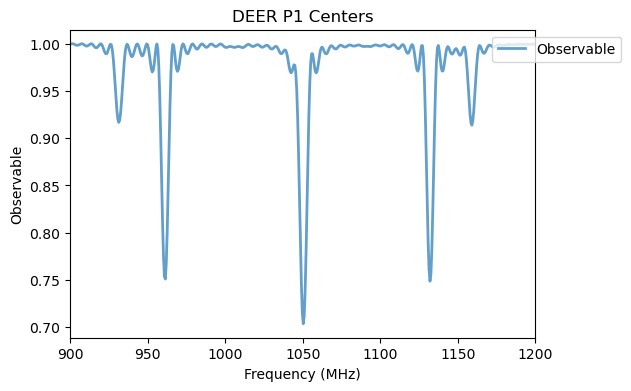

In [4]:
deer_analysis = Analysis(avg_deer)

deer_analysis.plot_results(title='DEER P1 Centers')

To plot these results we can use five sinc functions, as predefined in QuaCCAToo.

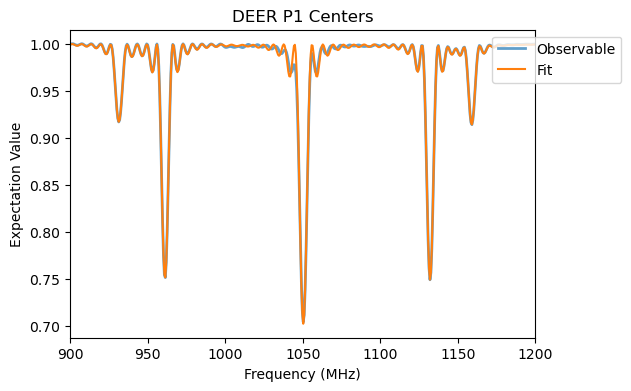

In [5]:
fit_guess = {
    'A1': .06,
    'A2': .25,
    'A3': .33,
    'A4': .25,
    'A5': .08,
    'gamma1': 5,
    'gamma2': 5,
    'gamma3': 5,
    'gamma4': 5,
    'gamma5': 5,
    'f01': 930,
    'f02': 960,
    'f03': 1050,
    'f04': 1130,
    'f05': 1160,
    'C': 1,
}

deer_analysis.run_fit(
    fit_model = Model(fit_five_sinc2),
    guess = fit_guess
)

deer_analysis.plot_fit(title='DEER P1 Centers')
deer_analysis.fit_params

# 2. Rabi

Now, we keep the frequency of the control field constant in one of the resonances and change the duration of the pulse.

In [6]:
B0 = (3911 - 1827)/2/28.025
w2 = 3 # RF Rabi frequency in MHz
freq = 1050.3
sim_2 = np.empty((6,4), dtype=object)
tp = np.linspace(0.01, 0.5, 200) # length of the RF pulse in us

for obs_idx in range(6):
    for rot_idx in range(4):
        qsys = P1(
            B0 = B0,
            rot_index = rot_idx,
            observable = obs_idx,
            N = 14
        )
        
        sim_2[obs_idx][rot_idx] = Rabi(
            pulse_duration = tp,
            system = qsys, # P1 system
            h1 = w2*qsys.h1, # control Hamiltonian
            pulse_params = {'f_pulse': freq}
        )

        sim_2[obs_idx][rot_idx].run()

Again we combined all simulations for different orientations and observables and plot the data.

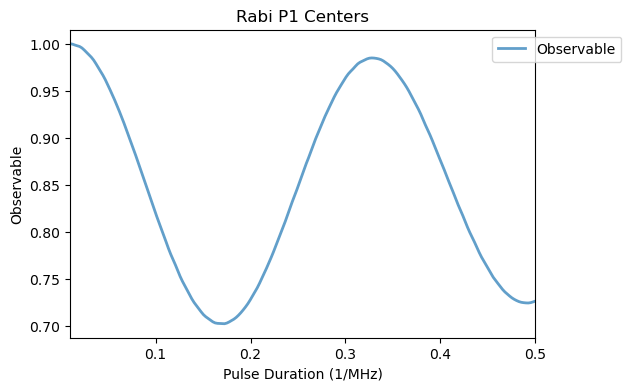

In [7]:
avg_rabi = Rabi(
            pulse_duration = tp,
            system = qsys, # P1 system
            h1 = w2*qsys.h1, # control Hamiltonian
            pulse_params = {'f_pulse': freq}
        )

avg_rabi.results = np.mean([sim_2[obs_idx][rot_idx].results for obs_idx in range(6) for rot_idx in range(4)], axis=0)

rabi_analysis = Analysis(avg_rabi)
rabi_analysis.plot_results(title='Rabi P1 Centers')

To fit the data em use a fit_rabi function.

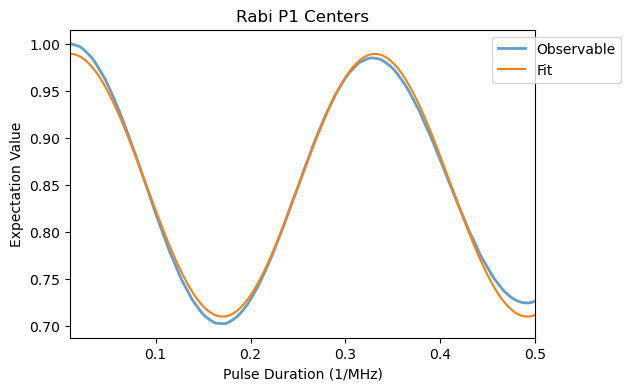

In [8]:
rabi_analysis.run_fit(
    fit_model = RabiModel()
)

rabi_analysis.plot_fit(title='Rabi P1 Centers')
rabi_analysis.fit_params